In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time
import json
import matplotlib.pyplot as plt

In [2]:
# read data from .npy files for formaldehyde casci(8,8) calculations

# !!! Change this to the correct path on your computer!
npy_folder = "/Users/rmandern/code/SCQED-PCQED/data/"

# these file names should still be good
E_npy_file = npy_folder + "HHep_fci_cc_pVTZ_Energies.npy"
Mu_npy_file = npy_folder + "HHep_fci_cc_pVTZ_Dipoles.npy"

# store energy eigenvalues in E_array 
E_array = np.load(E_npy_file)
# store dipole matrix elements in Mu_array
Mu_array = np.load(Mu_npy_file)


print(np.shape(E_array))
print(np.shape(Mu_array))
# print(Mu_array[1,1,:,:])
# print(E_array)
# print(Mu_array)

(784,)
(784, 784, 3)


In [3]:
# setup basic arguments to create an instance of the PFHamiltonianGenerator class
mol_str = """          
    H            
    He 1 0.776011            
    1 1
    symmetry c1  
"""


options_dict = {
    "basis": "cc-pVTZ",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}


cavity_free_dict = {
    'omega_value' : 0.9760568251,
    'lambda_vector' : np.array([0, 0, 0.01]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}

# create the instance of our PFHamiltonianGenerator class
instance = PFHamiltonianGenerator(mol_str, options_dict, cavity_free_dict)


Start SCF iterations:

Canonical RHF One-electron energy = -5.3268552796232527
CQED-RHF One-electron energy      = -5.3268095075551702
Nuclear repulsion energy          = 1.3638394576107813
Dipole energy                     = 0.0000007721741060
SCF Iteration   1: Energy = -2.9321956581445554   dE = -2.93220E+00   dRMS = 1.91850E-06
SCF Iteration   2: Energy = -2.9321956599609442   dE = -1.81639E-09   dRMS = 3.52323E-07
SCF Iteration   3: Energy = -2.9321956600202186   dE = -5.92744E-11   dRMS = 1.82852E-08
SCF Iteration   4: Energy = -2.9321956600203554   dE = -1.36779E-13   dRMS = 1.59803E-09
SCF Iteration   5: Energy = -2.9321956600203563   dE = -8.88178E-16   dRMS = 6.36875E-11
Total time for SCF iterations: 0.012 seconds 

QED-RHF   energy: -2.93219566 hartree
Psi4  SCF energy: -2.93224104 hartree
 Completed QED-RHF in 0.22968792915344238 seconds
 Completed 1HSO Build in 0.0017693042755126953 seconds
 Completed ERI Build in 0.03801679611206055 seconds 
 Completed 2D build in 0.048

In [4]:
# print(E_array)

In [5]:
# Define the range and increment
start = 0.025
stop = 0.1
increment = 0.005

# Create the array using numpy's arange function
lambda_array = np.arange(start, stop + increment, increment)
# print(lambda_array)
# print(len(lambda_array))


N_l = len(lambda_array)
N_el = 468
N_ph = 10
omega = 0.9654959009 

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_22 = np.zeros((N_l, N_el * N_ph))

ctr = 0
# loop over the lambda values
for i, lambda_val in enumerate(lambda_array):
    lambda_vector = np.array([0, 0, lambda_val])
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector, E_array, Mu_array)      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_22[ctr, :] = instance.PCQED_pf_eigs
    ctr += 1


In [6]:
# dim = np.ndim(_pcqed_22)
# print(np.shape(_pcqed_22))
# print(np.shape(_pcqed_22[1,:]))
# print(np.ndim(_pcqed_22[:,1]))
# print(_pcqed_22)
# print(_pcqed_22[0,:])
print(_pcqed_22[:,0])


[-2.97504814 -2.97498764 -2.97491615 -2.97483366 -2.97474018 -2.97463571
 -2.97452026 -2.97439383 -2.97425642 -2.97410805 -2.9739487  -2.9737784
 -2.97359714 -2.97340493 -2.97320178 -2.9729877  -2.97276268]


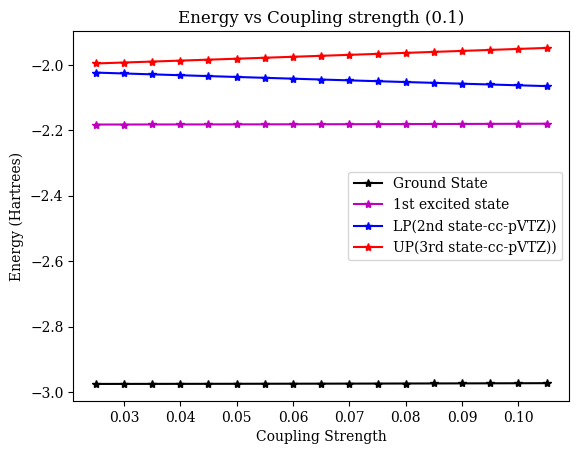

In [13]:
from matplotlib import cm
from matplotlib import rcParams



plt.plot(lambda_array, _pcqed_22[:,0],'k-', marker="*", label= "Ground State")
plt.plot(lambda_array, _pcqed_22[:,1], 'm-', marker="*",label = "1st excited state")
plt.plot(lambda_array, _pcqed_22[:,2],'b-', marker="*", label = "LP(2nd state-cc-pVTZ))")
plt.plot(lambda_array, _pcqed_22[:,3],'r-', marker="*", label = "UP(3rd state-cc-pVTZ))")
plt.ylabel('Energy (Hartrees)')
plt.xlabel('Coupling Strength')
plt.legend()
plt.savefig("Energy vs Coupling strength cc-pVTZ new lambda", dpi=150,bbox_inches='tight')
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 10
# plt.gca().yaxis.set_major_formatter('{:.12f}'.format)
#plt.plot(A0_list, e4, label = "E4")
plt.title("Energy vs Coupling strength (0.1)")
plt.show()

In [9]:
# Saving energies in numpy array form
E_pcqed_array = np.array(_pcqed_22)

# Making list from the array
E_list = E_pcqed_array.tolist()

# Making list of lambda value from array
lamda_val = lambda_array.tolist()

# Giving [x, y, z] form to the list
lambda_values = [[0, 0, round(val,3)] for val in lamda_val]


# set up base dictionary - some of this will be updated with each calculation
dictionary = {   
    "molecule": {
        "molecule_name": "HHe+",
        "geometry": [
            "\nH       \nHE            1    0.776011\n1 1\nsymmetry c1\n"
        ],
        "symbols": [
            "H",
            "He"
        ]
    },
       
        "basis_set" : "cc-pVTZ",
        "Photon basis" : "photon_number_basis", 
        "Number Photon States" : 10,
        "driver": "energy",
        "method" : "PCQED",
        "lambda" : lambda_values,
         "omega_value" : '0.9654959009',
    
        "return_result" : E_list,
}


# function to generate file names based on system details
def generate_file_name(dic):
    
    file_name = dic["molecule"]["molecule_name"] + "_"
    file_name += str(dictionary["basis_set"]) + "_"
    file_name += str(dictionary["method"]) + "_"
    file_name += str(dictionary["Number Photon States"]) + "_"
    file_name += str(dictionary["omega_value"]) + ".json"
    return file_name



# write to json file
file_name = generate_file_name(dictionary)
json_object = json.dumps(dictionary, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)

In [ ]:
# # Define the range and increment
# start = 0.0
# stop = 0.02
# increment = 0.001

# # Create the array using numpy's arange function
# lambda_array = np.arange(start, stop + increment, increment)
# print(lambda_array)
# print(len(lambda_array))


# N_R = 21
# d_array = np.linspace(1.4,2.2,N_R)
# N_l = len(lambda_array)
# N_el = 10
# N_ph = 2
# omega = 0.9760568251

# # create an array of zeros to store the PCQED eigenvalues for each value of d
# _pcqed_22 = np.zeros((len(lambda_array),N_l, N_el * N_ph))

# # loop over the lambda values
# for i, lambda_val in enumerate(lambda_array):
#     lambda_vector = np.array([0, 0, lambda_val])
#     ctr = 0
#     for d in d_array:
#         instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr])      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
#         _pcqed_22[ctr, :] = instance.PCQED_pf_eigs
#         ctr += 1
